<a href="https://colab.research.google.com/github/spacemaninSeoul/justpractice/blob/main/Using_Neural_Network_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. MNIST

MNIST 데이터셋은 0부터 9까지의 숫자를 예측하는 다중 분류(multi classification)문제로, 과거 NIST(National Institute of Standards of Technology, 미국 국립표준기술연구소)에서 수집한 손으로 직접 쓴 흑백의 숫자이다. 데이터는 숫자 이미지(28x28)와 각 이미지에 해당하는 레이블(0부터 9까지)로 이루어져 있고, 60,000개의 학습 데이터와 10,000개의 테스트 데이터로 구성되어 있다.

## 1) 데이터 살펴보기

In [1]:
# MNIST 데이터셋 다운받기
from tensorflow.keras.datasets.mnist import load_data

# 텐서플로 저장소에서 데이터를 다운 받는다.
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
# 데이터의 형태 파악하기
# 학습 데이터
print(x_train.shape, y_train.shape)
print(y_train)

# 테스트 데이터
print(x_test.shape, y_test.shape)
print(y_test)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]
(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]


학습 데이터는 60,000개의 숫자 이미지 데이터와 0에서 9로 이루어진 레이블로 구성된 것을 알 수 있다.

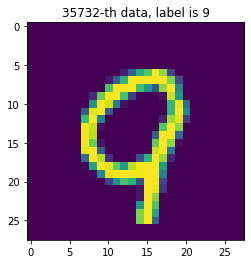

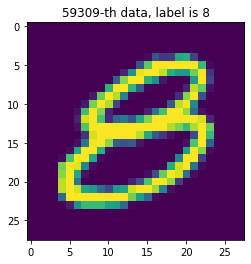

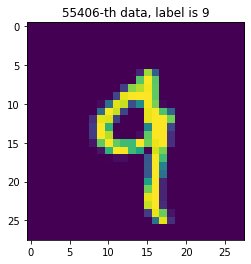

In [3]:
# 데이터 그려보기
import matplotlib.pyplot as plt
import numpy as np

sample_size = 3
# 0~59,999의 범위에서 무작위로 세 개의 정수를 뽑는다.
random_idx = np.random.randint(60000, size=sample_size)


for idx in random_idx:
  img = x_train[idx, :]
  label = y_train[idx]
  plt.figure()
  plt.imshow(img)
  plt.title('%d-th data, label is %d' % (idx, label))

학습 도중 모델의 검증을 위해 미리 검증 데이터셋을 만든다.

In [4]:
# 검증 데이터 만들기
from sklearn.model_selection import train_test_split

# 훈련/검증 데이터를 0.7/0.3의 비율로 분리한다.
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=777)

print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_val.shape} 레이블 {y_val.shape}')

훈련 데이터 (42000, 28, 28) 레이블 (42000,)
검증 데이터 (18000, 28, 28) 레이블 (18000,)


모델 학습을 위한 전처리 과정

In [5]:
# 모델 입력을 위한 데이터 전처리
num_x_train = x_train.shape[0]
num_x_val = x_val.shape[0]
num_x_test = x_test.shape[0]

# 모델의 입력으로 사용하기 위한 전처리 과정이다.
x_train = (x_train.reshape((num_x_train, 28 * 28))) / 255
x_val = (x_val.reshape((num_x_val, 28 * 28))) / 255
x_test = (x_test.reshape((num_x_test, 28 * 28))) / 255

print(x_train.shape)

(42000, 784)


Dense층에 데이터를 입력하기 위해 2차원 배열로 이루어진 숫자 이미지 데이터를 1차원 배열로 변환해야 한다. 예저 코드에서 (28, 28) 형태의 데이터를 784차원의 1차원 배열로 변환한 것을 볼 수 있다. 신경망은 입력 데이터의 스케일에 아주 민감하므로 적절한 전처리 과정이 필수이다. 이에 대한 한 가지 큰 이유로는 그래디언트 손실(Gradient Vanishing)과 그래디언트 폭발(Gradient Exploding)로 인해 학습이 진행되지 않기 때문입니다. 우리가 사용할 숫자 이미지 데이터는 각 픽셀 값이 0~255의 범위에 있기 때문에 255로 나누어 주었다. 이를 다시 표현하면 MinMax 알고리즘을 적용한 것과 같다.



경사 하강법을 사용할때 딥 러닝은 출력층에서 입력층으로 오차 그래디언트를 전파시키는 역전파 알고리즘을 사용한다. 하지만 이 알고리즘은 하위층으로 갈 수록 그래디언트가 작아지게 되어 하위층의 연결 가중치가 변경이 되지 않는 현상이 발생합니다. 이 문제를 그래디언트 손실이라고 합니다. 반대로 가중치가 너무 크게 변경된다면 그 현상을 그래디언트 폭주라고 합니다. 


In [6]:
# 모델 입력을 위한 레이블 전처리
from tensorflow.keras.utils import to_categorical

# 각 데이터의 레이블을 범주형 형태로 변경한다.
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 2) 모델 구성하기

Dense층을 여러 개 쌓아보도록한다. 항상 데이터를 입력받는 첫 번쨰 층은 데이터의 형태를 명시해야 한다는 점을 기억해야 한다. 모델은 784차원의 데이터를 입력으로 받고, 열 개의 출력을 갖는다.

In [7]:
# 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 한다.
# 784차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense층
model.add(Dense(64, activation = 'relu', input_shape = (784, )))
model.add(Dense(32, activation = 'relu')) # 32개의 출력을 갖는 Dense층
model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 갖는 신경망

범주형 데이터를 다루기에 마지막 층에서 소프트맥스 함수를 사용했다. 소프트맥스 함수에서 출력값의 의미는 해당 클래스에 속할 값이며, 출력값의 합은 항상 1이다. 이 때문에 소프트맥스 함수의 출력값을 확률로서 해석할 수 있다.

소프트맥스 함수는 일반적으로 확률을 구하는 방법과 비슷하므로 각 클래스에 해당하는 값들이 서로 영향을 줄 수 있어 비교에 용이하다.

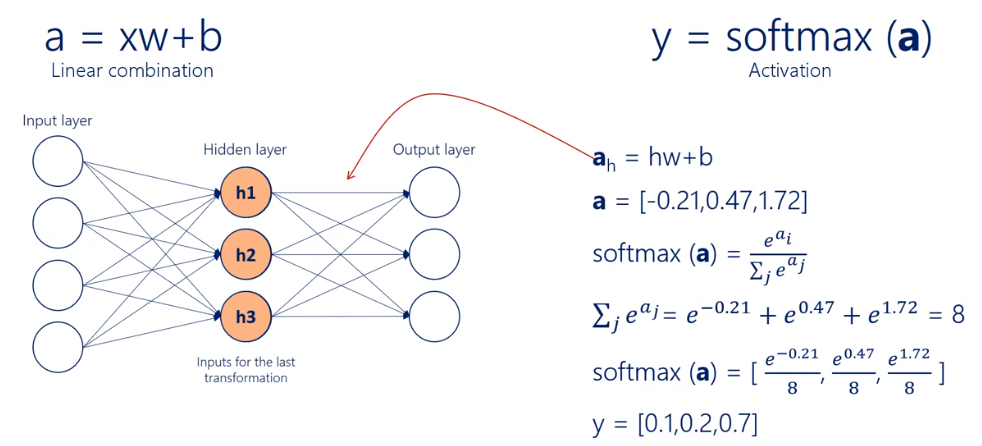

다음 예제에서 시그모이드 함수와 소프트맥스 함수를 통해 얻어지는 출력값을 비교한다.

In [8]:
# 소프트맥스와 시그모이드 값의 비교
def softmax(arr):
  m = np.max(arr)
  arr = arr - m # exp의 오버플로우 방지
  arr = np.exp(arr)
  return arr / np.sum(arr)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

case_1 = np.array([3.1 ,3.0, 2.9])
case_2 = np.array([2.0, 1.0, 0.7])

np.set_printoptions(precision=3) # numpy 소수점 제한
print(f'sigmoid {sigmoid(case_1)}, softmax {softmax(case_1)}')
print(f'sigmoid {sigmoid(case_2)}, softmax {softmax(case_2)}')

sigmoid [0.957 0.953 0.948], softmax [0.367 0.332 0.301]
sigmoid [0.881 0.731 0.668], softmax [0.61  0.224 0.166]


시그모이드 함수를 통해 얻은 값의 비교보다 소프트맥스 함수를 통해 얻은 값의 비교가 훨씬 수월한 것을 알 수 있다.

모델 구성의 마지막 단계는 손실 함수, 옵티 마이저, 평가지표를 설정하는 것이다. 다중 분류 문제에서의 손실 함수는 categorical_crossentropy 함수를 사용한다. 크로스 엔트로피(cross entropy)는 정보이론에서 파생되었으며, 이를 손실 함수로 사용했을 때 실제값과 예측값이 같은 값을 가지는 방향으로 학습된다. 서로의 값이 틀린 경우에는 로그 함수의 특징에 따라 무한대로 발산하게 되고 동일한 경우는 0으로 수렴하기 때문이다.

In [9]:
# 학습과정 설정
model.compile(optimizer='adam',# 옵티마이저 : Adam
              loss = 'categorical_crossentropy', # 손실함수 : categorical_crossentropy
              metrics = ['acc'], # 모니터링할 평가지표 : acc
)

주로 사용하는 Adam 옵티마이저의 기본 학습률은 0.001로 설정되어 있기에 변경하지 않고 사용한다.

## 3) 모델 학습

학습 도중 모델의 검증을 위해 미리 만들어둔 검증 데이터셋을 활용한다. validation_data 인자에 검증 데이터셋을 전달했으므로 매 에폭의 끝에서 이를 사용하여 학습중인 모델에 대한 검증을 진행한다. 모델은 128의 배치 크기를 사용하고 전체 데이터를 30회 반복한다.

In [10]:
# 모델 학습
history = model.fit(x_train, y_train,
                    epochs = 30,
                    batch_size = 128,
                    validation_data = (x_val, y_val))

Epoch 1/30
329/329 [==============================] - 2s 5ms/step - loss: 0.4987 - acc: 0.8636 - val_loss: 0.2610 - val_acc: 0.9272
Epoch 2/30
329/329 [==============================] - 2s 7ms/step - loss: 0.2226 - acc: 0.9360 - val_loss: 0.2040 - val_acc: 0.9407
Epoch 3/30
329/329 [==============================] - 3s 8ms/step - loss: 0.1699 - acc: 0.9511 - val_loss: 0.1674 - val_acc: 0.9508
Epoch 4/30
329/329 [==============================] - 3s 8ms/step - loss: 0.1403 - acc: 0.9594 - val_loss: 0.1518 - val_acc: 0.9543
Epoch 5/30
329/329 [==============================] - 3s 8ms/step - loss: 0.1176 - acc: 0.9660 - val_loss: 0.1351 - val_acc: 0.9605
Epoch 6/30
329/329 [==============================] - 3s 8ms/step - loss: 0.1013 - acc: 0.9700 - val_loss: 0.1280 - val_acc: 0.9613
Epoch 7/30
329/329 [==============================] - 3s 9ms/step - loss: 0.0892 - acc: 0.9732 - val_loss: 0.1257 - val_acc: 0.9641
Epoch 8/30
329/329 [==============================] - 1s 4ms/step - loss: 0.

이제 모델의 학습 과정을 그리도록 한다. model.fit() 함수는 History 객체를 반환한다. 이 객체는 History 속성이 있는데, 학습 중 학습 데이터뿐만 아니라 검증 데이터의 손실값과 평가지표의 값을 기록한다. History는 이런 값을 사전(dictionary) 형태로 저장하고 있다.

In [11]:
# history를 통해 확인할 수 있는 값 출력하기
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

검증 데이터를 통해 얻을 수 있는 손실값 또는 평가지표에는 'val_'이라는 수식어가 붙는다.

History 객체를 통해 손실값과 정확도를 그림으로 그려보도록 한다. 에폭이 진행되면서 손실값과 평가지표를 직접 모니터링할 수도 있지만, 모델의 history를 사용하여 학습 과정을 그래프로 그려보면 결과를 더욱 직관적으로 확인할 수 있다.

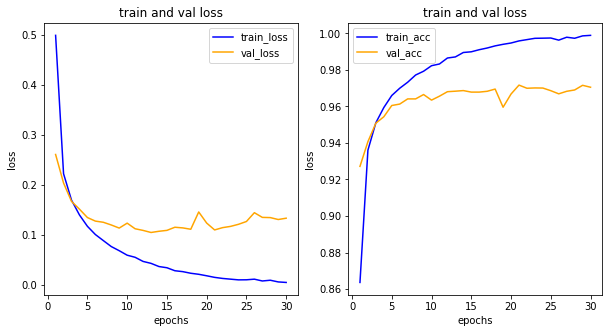

In [12]:
# 학습 결과 그리기.
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우에는 val_ 수식어가 붙는다.

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 5))

# 학습 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color='orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color='blue', label='train_acc')
ax2.plot(epochs, val_acc, color='orange', label='val_acc')
ax2.set_title('train and val loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('loss')
ax2.legend()

plt.show()

위에서 대략 5에폭까지는 올바르게 학습되고 있지만, 그 이후에는 두 그래프가 점점 벌어지는 모습을 볼 수 있다. 학습 과정에서 이와 같은 현상이 나타났을 때, 모델이 과대적합되었다고 표현할 수 있다. 과대적합 문제가 나타날 경우 데이터 특성, 모델 구조 등을 수정하고 재학습시키는 방법이 있지만, 먼저 과대적합이 진행되기 전(위의 경우에서는 5에폭)까지의 모델을 사용하여 결과를 확인해보고 기록해두는 것이 좋다.

## 4) 예측하고 정답과 비교하기

model.evaluate() 함수를 사용해 모델 성능을 확인한다.

In [13]:
# 모델 평가
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1314 - acc: 0.9720


[0.13141311705112457, 0.972000002861023]

출력값의 첫 번째 값은 손실값, 두 번째 값은 정확도를 나타낸다.

다음으로 model.predict() 함수를 이용하여 각 데이터에 대한 확률을 예측한다.

In [14]:
# 학습된 모델을 통해 값 예측
import numpy as np

results = model.predict(x_test)
print(results.shape)
np.set_printoptions(precision=7)
print(f'각 클래스에 속할 확률 : \n{results [0]}')

(10000, 10)
각 클래스에 속할 확률 : 
[1.5815869e-14 1.7190405e-18 4.0409123e-10 1.0684021e-05 1.3022800e-12
 1.1966389e-11 1.9953231e-19 9.9998927e-01 2.9924888e-13 1.5243360e-08]


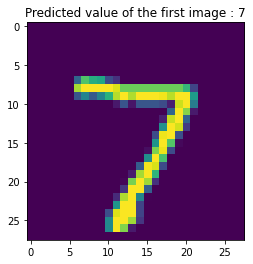

In [15]:
# 예측값을 그려 확인하기
import matplotlib.pyplot as plt
arg_results = np.argmax(results, axis = -1) # 가장 큰 값의 인덱스를 가져온다.
plt.imshow(x_test[0].reshape(28, 28))
plt.title('Predicted value of the first image : ' + str(arg_results[0]))
plt.show()

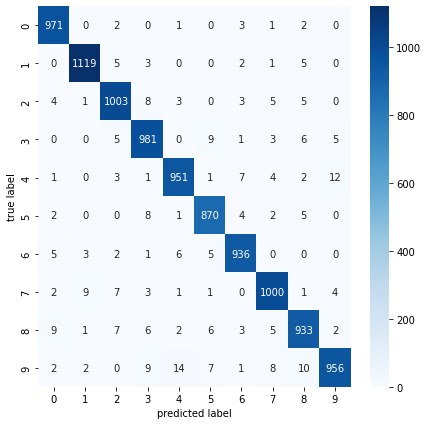

In [17]:
# 모델 평가 방법 1 - 혼돈행렬
# sklearn.metrics 모듈은 여러 가지 평가 지표에 관한 기능을 제공한다.
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 혼동행렬을 만든다.
plt.figure(figsize=(7, 7))
cm = confusion_matrix(np.argmax(y_test, axis = -1), np.argmax(results, axis= - 1))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

학습한 모델이 4와 9을 분류할 때 가장 많이 혼란스러워하는 것을 볼 수 있다. 이처럼 혼동행렬을 사용하면 데이터에 대한 모델의 강점과 약점을 파악하기에 유용하다.

또 다른 방법으로 분류 보고서(classification_report)는 여러 가지 평가지표를 설명한다.

In [18]:
# 모델 평가 방법 2 - 분류 보고서
print('\n', classification_report(np.argmax(y_test, axis = -1),
                                  np.argmax(results, axis = -1)))


               precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.97      0.98      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# 2. Fashion-MNIST

## 1) 데이터 살펴보기


In [19]:
from tensorflow.keras.datasets.fashion_mnist import load_data
# Fashion-MNIST 데이터를 다운받는다.
(x_train, y_train), (x_test, y_test)  = load_data()
print(x_train.shape, x_test.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


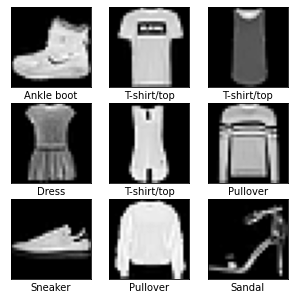

In [21]:
# 데이터 그려보기
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(777)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_size = 9
random_idx = np.random.randint(60000, size=sample_size)

plt.figure(figsize=(5, 5))
for i, idx in enumerate(random_idx):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i], cmap='gray')
  plt.xlabel(class_names[y_train[i]])
plt.show()

In [22]:
# 전처리 및 검증 데이터셋 만들기
# 0~1 범위로 만든다.
x_train = x_train / 255
x_test = x_test / 255

from tensorflow.keras.utils import to_categorical
# 각 데이터의 레이블을 범주형 형태로 변경한다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 검증 데이터셋 만들기
from sklearn.model_selection import train_test_split

# 학습/테스트 데이터를 0.7/0.3 비율로 분리
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=777)

## 2) 모델 구성과 학습
784차원의 데이터를 입력으로 받고, 열 개의 출력을 가지는 모델을 구성한다.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

first_model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 한다.
first_model.add(Flatten(input_shape = (28, 28))) # 28, 28 -> (28 * 28)
first_model.add(Dense(64, activation = 'relu')) # 64개의 출력을 갖는 Dense층
first_model.add(Dense(32, activation = 'relu')) # 32개의 출력을 갖는 Dense층
first_model.add(Dense(10, activation = 'softmax')) # 10개의 출력을 갖는 신경망

위 코드에선 MNIST 데이터셋의 코드와 다르게 (28, 28)로 이루어진 의류 이미지 데이터를 (28 * 28) 형태로 변환하는 전처리 과정을 생략했다. 대신 모델의 첫 번째 층에 Flatten층을 추가한다.

Flatten층은 배치 크기를 제외하고 데이터를 1차원 배열의 형태로 변환한다. 예를 들어, (128, 6, 2, 2)를 입력하면 (128, 24)의 형태로 변환하여 출력한다. 128은 배치 크기이기 때문에 영향을 받지 않는다.

모델의 학습 과정을 설정하고 학습을 진행한다.

In [24]:
# 학습 과정 설정 및 학습하기
first_model.compile(optimizer='adam', # 옵티마이저 : Adam
                    loss = 'categorical_crossentropy', # 손실함수 : categorical_crossentropy,
                    metrics = ['acc'] # 모니터링 할 평가지표: acc
                    )

first_history = first_model.fit(x_train, y_train,
                                epochs = 30,
                                batch_size = 128,
                                validation_data = (x_val, y_val))

Epoch 1/30
329/329 [==============================] - 2s 5ms/step - loss: 0.6776 - acc: 0.7719 - val_loss: 0.4627 - val_acc: 0.8418
Epoch 2/30
329/329 [==============================] - 2s 5ms/step - loss: 0.4421 - acc: 0.8464 - val_loss: 0.4159 - val_acc: 0.8572
Epoch 3/30
329/329 [==============================] - 2s 5ms/step - loss: 0.4002 - acc: 0.8570 - val_loss: 0.3802 - val_acc: 0.8677
Epoch 4/30
329/329 [==============================] - 2s 5ms/step - loss: 0.3719 - acc: 0.8665 - val_loss: 0.4120 - val_acc: 0.8574
Epoch 5/30
329/329 [==============================] - 3s 8ms/step - loss: 0.3518 - acc: 0.8730 - val_loss: 0.3705 - val_acc: 0.8683
Epoch 6/30
329/329 [==============================] - 2s 6ms/step - loss: 0.3370 - acc: 0.8785 - val_loss: 0.3718 - val_acc: 0.8661
Epoch 7/30
329/329 [==============================] - 1s 5ms/step - loss: 0.3276 - acc: 0.8812 - val_loss: 0.3540 - val_acc: 0.8758
Epoch 8/30
329/329 [==============================] - 1s 5ms/step - loss: 0.

적은 수의 Dense층만 사용해도 높은 정확도를 얻을 수 있었다. 더 많은 수의 은닉 유닛을 사용하는 Dense층을 추가하여 더 깊은 신경망을 만들어보고 결과를 비교해보도록 한다.

In [26]:
# 두 번째 모델 구성
second_model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 한다.
second_model.add(Flatten(input_shape = (28, 28))) # (28, 28) - > (28 * 28)
# 128개의 출력을 가지는 Dense층을 추가한다.
second_model.add(Dense(128, activation = 'relu'))
# 64개의 출력을 가지는 Dense층을 추가한다.
second_model.add(Dense(128, activation = 'relu'))
# 32개의 출력을 가지는 Dense층을 추가한다.
second_model.add(Dense(32, activation = 'relu'))
# 10개의 출력을 가지는 신경망을 추가한다.
second_model.add(Dense(10, activation = 'softmax'))

second_model.compile(optimizer='adam', # 옵티마이저: Adam
                     loss = 'categorical_crossentropy', # 손실 함수 : categorical_crossentropy
                     metrics = ['acc'] # 모니터링 할 평가지표 : acc
                     )

second_history = second_model.fit(x_train, y_train,
                                  epochs = 30,
                                  batch_size = 128,
                                  validation_data = (x_val, y_val))

Epoch 1/30
329/329 [==============================] - 4s 9ms/step - loss: 0.6191 - acc: 0.7898 - val_loss: 0.4602 - val_acc: 0.8374
Epoch 2/30
329/329 [==============================] - 2s 6ms/step - loss: 0.4112 - acc: 0.8542 - val_loss: 0.4189 - val_acc: 0.8483
Epoch 3/30
329/329 [==============================] - 2s 6ms/step - loss: 0.3679 - acc: 0.8671 - val_loss: 0.3917 - val_acc: 0.8583
Epoch 4/30
329/329 [==============================] - 2s 7ms/step - loss: 0.3378 - acc: 0.8772 - val_loss: 0.3458 - val_acc: 0.8748
Epoch 5/30
329/329 [==============================] - 2s 7ms/step - loss: 0.3151 - acc: 0.8843 - val_loss: 0.3301 - val_acc: 0.8817
Epoch 6/30
329/329 [==============================] - 2s 7ms/step - loss: 0.3027 - acc: 0.8884 - val_loss: 0.3480 - val_acc: 0.8734
Epoch 7/30
329/329 [==============================] - 2s 7ms/step - loss: 0.2820 - acc: 0.8954 - val_loss: 0.3275 - val_acc: 0.8839
Epoch 8/30
329/329 [==============================] - 2s 7ms/step - loss: 0.

직관적으로 비교하기 위해 History 객체를 사용해 손실값과 정확도를 그려본다.

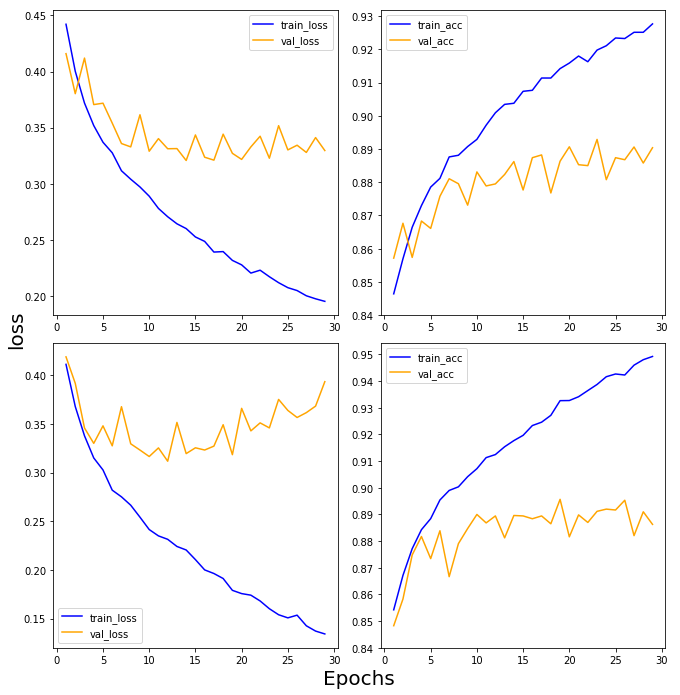

In [29]:
# 두 모델의 학습 과정 그려보기
import numpy as np
import matplotlib.pyplot as plt

def draw_loss_acc(history_1, history_2, epochs):
  his_dict_1 = history_1.history
  his_dict_2 = history_2.history
  keys = list(his_dict_1.keys())

  epochs = range(1, epochs)
  fig = plt.figure(figsize= (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  # axis 선과 ax의 축 레이블을 제거한다.
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top=False,
                 bottom=False, left=False, right=False)
  
  for i in range(len(his_dict_1)):
    temp_ax = fig.add_subplot(2, 2, i + 1)
    temp = keys[i%2]
    val_temp = keys[(i + 2)%2 + 2]
    temp_history = his_dict_1 if i < 2 else his_dict_2
    temp_ax.plot(epochs , temp_history[temp][1:],
                 color = 'blue', label = 'train_' + temp)
    temp_ax.plot(epochs, temp_history[val_temp][1:],
                 color = 'orange', label = val_temp)
    if(i == 1 or i==3):
      start, end = temp_ax.get_ylim()
      temp_ax.yaxis.set_ticks(np.arange(np.round(start, 2), end, 0.01))
    temp_ax.legend()
  ax.set_ylabel('loss', size=20)
  ax.set_xlabel('Epochs', size=20)
  plt.tight_layout()
  plt.show()

draw_loss_acc(first_history, second_history, 30)

1행은 첫 번째 모델의 결과이고, 2행은 두 번째 모델의 결과이다. Dense(128)층을 추가한 두 번째 모델은 첫 번째 모델보다 빠르게 수렴하며 높은 정확도와 낮은 손실값을 보인다. 하지만 과대적합 문제 역시 발생한다. 첫 번째 모델(20에폭)보다 두 번째 모델(10 에폭)이 train_loss와 val_loss가 벌어지는 지점이 상대적으로 빠른 것을 볼 수 있다.

만약 결과 예측을 위해 두 모델 중 한 가지를 사용해야 한다면 두 번째 모델을 기준으로 과대적합이 일어나기 전 가장 높은 성능을 가지는 8에폭까지만 모델을 학습시키고 이를 최종 성능으로 사용해야할 것이다.

위의 결과는 모델을 깊게 구성하면 높은 성능을 얻을 수 있는 만큼, 모델이 가지는 파라미터의 수가 매우 많아지기 때문에 과대적합 문제에도 많이 노출될 수 있음을 보여준다. 따라서 모델의 깊이는 데이터에 알맞게 조절될 필요가 있다. 어느 정도가 적절한 모델의 깊이인지 파악하기 어렵다면, 유명 데이터셋이나 유사 분야에서 높은 성능을 보여준 모델의 구조를 참고하여 구성해보고 실험을 진행하는 것이 좋다.